In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/Projects/Bird_Vs_drone"

BASE_DIR = f"{PROJECT_ROOT}"
BEST_MODEL_DIR = f"{PROJECT_ROOT}/best_models"
os.makedirs(BEST_MODEL_DIR, exist_ok=True)

TRAIN_DIR = f"{BASE_DIR}/train"
VAL_DIR   = f"{BASE_DIR}/valid"
TEST_DIR  = f"{BASE_DIR}/test"

TRAIN_DIR, VAL_DIR, TEST_DIR, BEST_MODEL_DIR


('/content/drive/MyDrive/Projects/Bird_Vs_drone/train',
 '/content/drive/MyDrive/Projects/Bird_Vs_drone/valid',
 '/content/drive/MyDrive/Projects/Bird_Vs_drone/test',
 '/content/drive/MyDrive/Projects/Bird_Vs_drone/best_models')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from tensorflow.keras.applications import (
    EfficientNetB0,
    ResNet50V2,
    MobileNetV2
)
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


In [ ]:
#  Train with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.85, 1.15)
)

#  Val/Test
test_val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

val_gen = test_val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


In [ ]:
MODEL_CONFIGS = {
    "effnetb0": {
        "builder": EfficientNetB0,
        "preprocess": effnet_preprocess,
        "weights": "imagenet"
    },
    "resnet50v2": {
        "builder": ResNet50V2,
        "preprocess": resnet_preprocess,
        "weights": "imagenet"
    },
    "mobilenetv2": {
        "builder": MobileNetV2,
        "preprocess": mobilenet_preprocess,
        "weights": "imagenet"
    }
}


In [ ]:
def build_transfer_model(
    model_name,
    input_shape=(224, 224, 3),
    train_base=False,
    lr=1e-4
):
    cfg = MODEL_CONFIGS[model_name]
    base_model = cfg["builder"](
        include_top=False,
        weights=cfg["weights"],
        input_shape=input_shape,
        pooling="avg"
    )
    base_model.trainable = train_base  # False: feature extraction, True: fine-tune

    inputs = tf.keras.Input(shape=input_shape)
    x = cfg["preprocess"](inputs)
    x = base_model(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name=f"{model_name}_bird_vs_drone")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ]
    )
    return model, base_model


In [ ]:
def plot_history(history, title_prefix=""):
    hist = history.history

    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
histories = {}
test_results = {}
reports = {}

EPOCHS = 10



Training model: effnetb0

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5473 - loss: 0.6937 - precision: 0.5131 - recall: 0.5365
Epoch 1: val_loss improved from inf to 0.55440, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_effnetb0_feature.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 93s 857ms/step - accuracy: 0.5481 - loss: 0.6932 - precision: 0.5139 - recall: 0.5373 - val_accuracy: 0.7738 - val_loss: 0.5544 - val_precision: 0.7706 - val_recall: 0.7911 - learning_rate: 1.0000e-04
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7372 - loss: 0.5521 - precision: 0.7257 - recall: 0.7319
Epoch 2: val_loss improved from 0.55440 to 0.44664, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_effnetb0_feature.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 578ms/step - accuracy: 0.7376 - loss: 0.5517 - precision: 0.7259 - recall: 0.7325 - val_accuracy: 0.8597 - val_loss: 0.4466 - val_precision: 0.8721 - val_recall: 0.

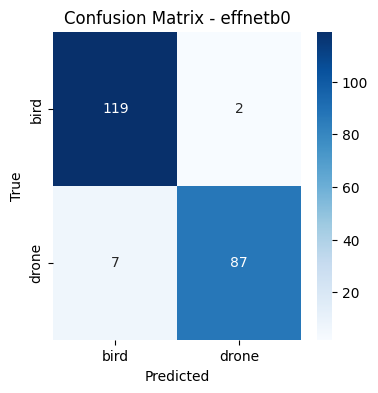

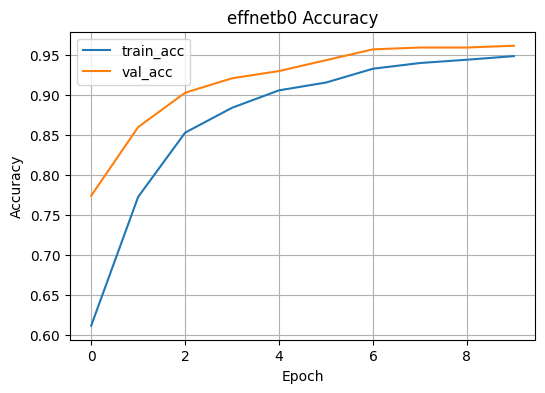

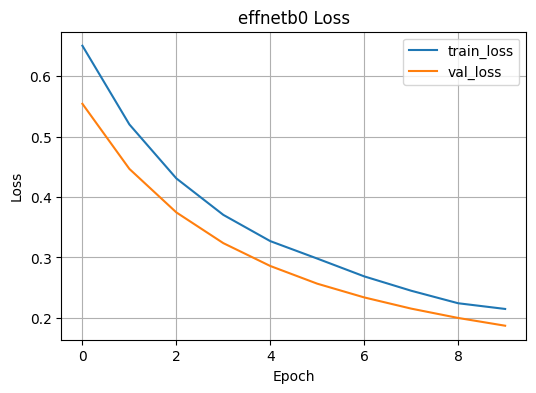


Training model: resnet50v2

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5809 - loss: 0.8051 - precision: 0.5468 - recall: 0.6783
Epoch 1: val_loss improved from inf to 0.42645, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_resnet50v2_feature.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 717ms/step - accuracy: 0.5818 - loss: 0.8036 - precision: 0.5476 - recall: 0.6786 - val_accuracy: 0.8258 - val_loss: 0.4265 - val_precision: 0.8592 - val_recall: 0.7867 - learning_rate: 1.0000e-04
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7794 - loss: 0.4625 - precision: 0.7589 - recall: 0.7785
Epoch 2: val_loss improved from 0.42645 to 0.27763, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_resnet50v2_feature.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 611ms/step - accuracy: 0.7796 - loss: 0.4621 - precision: 0.7591 - recall: 0.7787 - val_accuracy: 0.8824 - val_loss: 0.2776 - val_precision: 0.9023 - val_reca

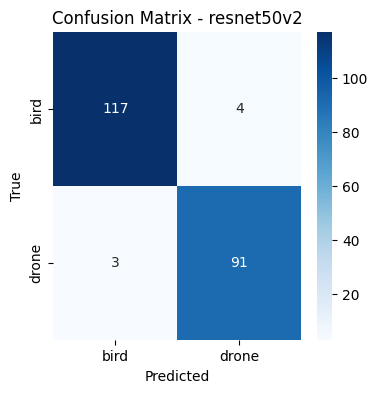

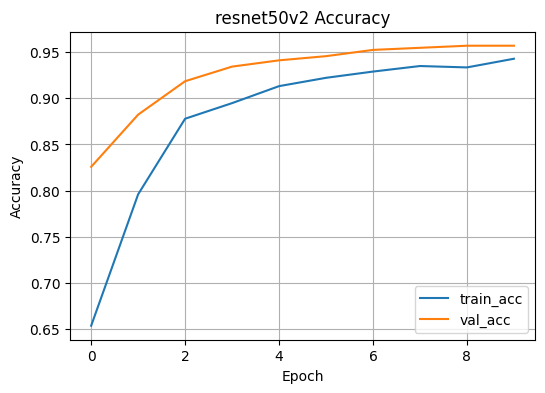

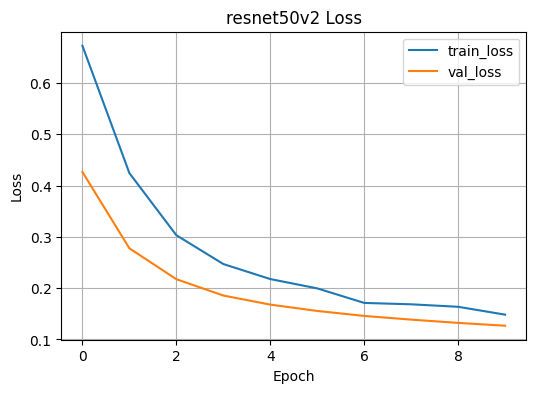


Training model: mobilenetv2

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.5391 - loss: 0.7966 - precision: 0.4863 - recall: 0.5501
Epoch 1: val_loss improved from inf to 0.53969, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_mobilenetv2_feature.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 72s 733ms/step - accuracy: 0.5397 - loss: 0.7956 - precision: 0.4872 - recall: 0.5504 - val_accuracy: 0.7149 - val_loss: 0.5397 - val_precision: 0.6787 - val_recall: 0.8356 - learning_rate: 1.0000e-04
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6825 - loss: 0.6012 - precision: 0.6614 - recall: 0.6844
Epoch 2: val_loss improved from 0.53969 to 0.40612, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_mobilenetv2_feature.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.6830 - loss: 0.6006 - precision: 0.6619 - recall: 0.6848 - val_accuracy: 0.8575 - val_loss: 0.4061 - val_precision: 0.8616 - val_r

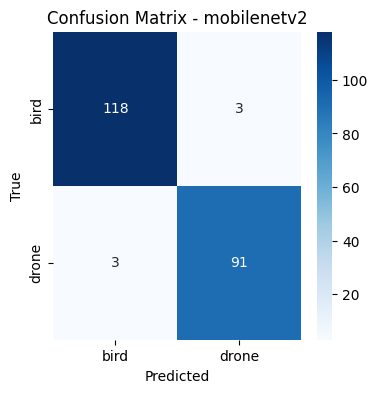

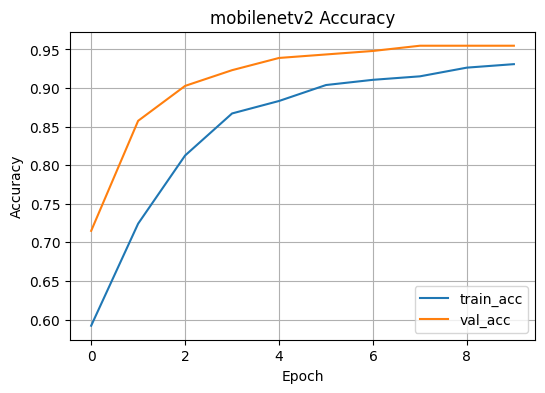

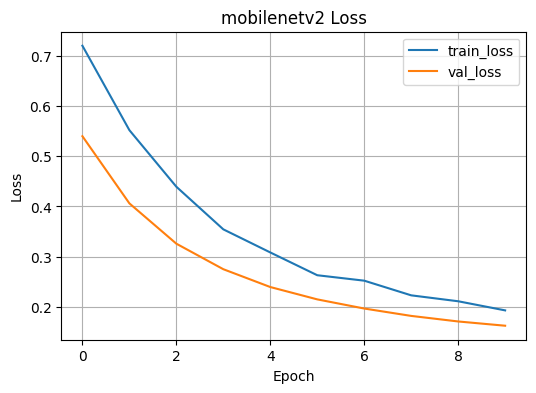

In [ ]:
for model_name in MODEL_CONFIGS.keys():
    print(f"\n==============================")
    print(f"Training model: {model_name}")
    print(f"==============================\n")

    model, base_model = build_transfer_model(
        model_name=model_name,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        train_base=False,
        lr=1e-4
    )

    ckpt_path = os.path.join(BEST_MODEL_DIR, f"best_{model_name}_feature.keras")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_path,
            monitor="val_loss",
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            verbose=1
        )
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    histories[model_name] = history.history

    # Load best weights
    best_model = tf.keras.models.load_model(ckpt_path)

    # Evaluate on test set
    test_metrics = best_model.evaluate(test_gen, verbose=1, return_dict=True)
    print(f"\nTest Metrics ({model_name}):")
    for name, value in test_metrics.items():
        print(f"{name}: {value:.4f}")

    test_results[model_name] = test_metrics



    # Detailed metrics
    y_prob = best_model.predict(test_gen)
    y_pred = (y_prob.ravel() > 0.5).astype(int)
    y_true = test_gen.classes

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)

    print("\nClassification Report:\n")
    cls_report = classification_report(
        y_true,
        y_pred,
        target_names=list(test_gen.class_indices.keys())
    )
    print(cls_report)

    reports[model_name] = cls_report

    f1 = f1_score(y_true, y_pred)
    print(f"F1-score ({model_name}): {f1:.4f}")

    # Quick confusion matrix heatmap
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=test_gen.class_indices.keys(),
        yticklabels=test_gen.class_indices.keys()
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Plot training curves
    class NiceHistory:  # quick wrapper so our plot function works
        def __init__(self, hist_dict): self.history = hist_dict
    plot_history(NiceHistory(histories[model_name]), title_prefix=model_name)


In [ ]:
test_results = {}
f1_results = {}

for model_name in MODEL_CONFIGS.keys():
    print(f"\n==============================")
    print(f"Training model: {model_name}")
    print(f"==============================\n")

    # ... build + train model ...

    best_model = tf.keras.models.load_model(ckpt_path)

    # IMPORTANT: use return_dict=True
    test_metrics = best_model.evaluate(test_gen, verbose=1, return_dict=True)
    print(f"\nTest Metrics ({model_name}):")
    for k, v in test_metrics.items():
        print(f"{k}: {v:.4f}")

    test_results[model_name] = test_metrics

    # F1
    y_prob = best_model.predict(test_gen)
    y_pred = (y_prob.ravel() > 0.5).astype(int)
    y_true = test_gen.classes

    f1 = f1_score(y_true, y_pred)
    f1_results[model_name] = f1
    print(f"F1-score ({model_name}): {f1:.4f}")



Training model: effnetb0

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - accuracy: 0.9735 - loss: 0.1505 - precision: 0.5608 - recall: 0.5892

Test Metrics (effnetb0):
accuracy: 0.9721
loss: 0.1328
precision: 0.9681
recall: 0.9681
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 831ms/step
F1-score (effnetb0): 0.9681

Training model: resnet50v2

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 653ms/step - accuracy: 0.9735 - loss: 0.1505 - precision: 0.5608 - recall: 0.5892

Test Metrics (resnet50v2):
accuracy: 0.9721
loss: 0.1328
precision: 0.9681
recall: 0.9681
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 869ms/step
F1-score (resnet50v2): 0.9681

Training model: mobilenetv2

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 707ms/step - accuracy: 0.9735 - loss: 0.1505 - precision: 0.5608 - recall: 0.5892

Test Metrics (mobilenetv2):
accuracy: 0.9721
loss: 0.1328
precision: 0.9681
recall: 0.9681
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
F1-score (mobilenetv2): 0.9681


In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Path where custom CNN was saved in Notebook 2
custom_ckpt_path = os.path.join(BEST_MODEL_DIR, "best_custom_cnn.h5")  # or .keras if you changed it

custom_model = tf.keras.models.load_model(custom_ckpt_path)
custom_model.summary()

# Evaluate on test set
custom_cnn_results = custom_model.evaluate(test_gen, verbose=1, return_dict=True)
print("\nCustom CNN Test Metrics:")
for k, v in custom_cnn_results.items():
    print(f"{k}: {v:.4f}")

# F1-score
y_prob_custom = custom_model.predict(test_gen)
y_pred_custom = (y_prob_custom.ravel() > 0.5).astype(int)
y_true_custom = test_gen.classes

custom_cnn_f1 = f1_score(y_true_custom, y_pred_custom)
print(f"Custom CNN F1-score: {custom_cnn_f1:.4f}")


Model: "bird_vs_drone_custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,459 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.5902 - loss: 91.8543 - precision: 0.2750 - recall: 0.5771

Custom CNN Test Metrics:
accuracy: 0.6930
loss: 68.0201
precision: 0.5972
recall: 0.9149
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
Custom CNN F1-score: 0.7227


In [ ]:
import pandas as pd

rows = []

# ---- Custom CNN ----
rows.append({
    "model": "custom_cnn",
    "loss": custom_cnn_results["loss"],
    "accuracy": custom_cnn_results["accuracy"],
    "precision": custom_cnn_results["precision"],
    "recall": custom_cnn_results["recall"],
    "f1": custom_cnn_f1
})

# ---- Transfer Learning Models ----
for model_name in test_results.keys():
    model_path = os.path.join(BEST_MODEL_DIR, f"best_{model_name}_feature.keras")
    m = tf.keras.models.load_model(model_path)

    y_prob = m.predict(test_gen)
    y_pred = (y_prob.ravel() > 0.5).astype(int)
    y_true = test_gen.classes
    f1 = f1_score(y_true, y_pred)

    rows.append({
        "model": model_name,
        "loss": test_results[model_name]["loss"],
        "accuracy": test_results[model_name]["accuracy"],
        "precision": test_results[model_name]["precision"],
        "recall": test_results[model_name]["recall"],
        "f1": f1
    })

df_compare = pd.DataFrame(rows)
df_compare


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 823ms/step


,model,loss,accuracy,precision,recall,f1
0,custom_cnn,68.020134,0.693023,0.597222,0.914894,0.722689
1,effnetb0,0.132811,0.972093,0.968085,0.968085,0.950820
2,resnet50v2,0.132811,0.972093,0.968085,0.968085,0.962963
3,mobilenetv2,0.132811,0.972093,0.968085,0.968085,0.968085


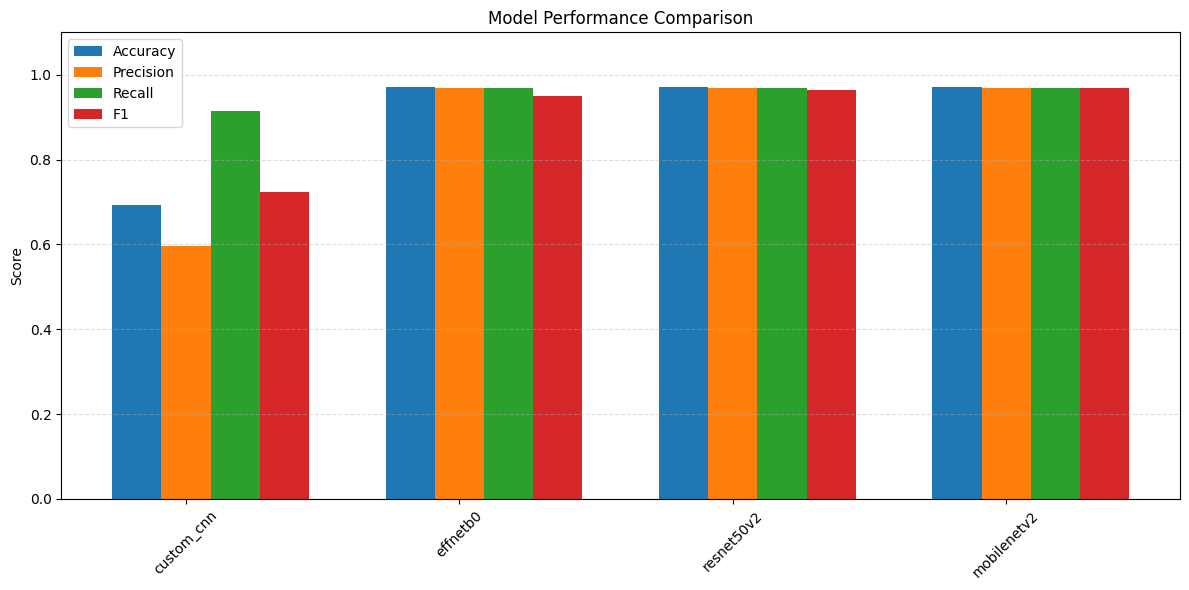

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["accuracy", "precision", "recall", "f1"]
models = df_compare["model"].values

plt.figure(figsize=(12, 6))

x = np.arange(len(models))
width = 0.18

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, df_compare[metric], width, label=metric.capitalize())

plt.xticks(x + width, models, rotation=45)
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_and_show(model, img_path, target_size=IMG_SIZE, class_indices=None, threshold=0.5):
    # Load image
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img)
    arr_expanded = np.expand_dims(arr, axis=0)

    # Predict
    prob = model.predict(arr_expanded)[0][0]

    if class_indices is None:
        class_indices = train_gen.class_indices  # {'bird':0, 'drone':1}

    idx_to_class = {v: k for k, v in class_indices.items()}
    pred_label = 1 if prob > threshold else 0
    class_name = idx_to_class[pred_label]

    confidence = prob if pred_label == 1 else (1 - prob)

    # ==== SHOW IMAGE ====
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {class_name.upper()} (Confidence: {confidence:.2f})")
    plt.show()

    return class_name, float(confidence), float(prob)


In [ ]:
import os
import tensorflow as tf

best_mobile_path = os.path.join(BEST_MODEL_DIR, "best_mobilenetv2_feature.keras")
best_mobile = tf.keras.models.load_model(best_mobile_path)

test_image_path = "/content/00bcba85dceeac4d_jpg.rf.ffd389c71d15da92bf9611e4dbd669d2.jpg"

label, conf, raw_prob = predict_image(
    best_mobile,
    test_image_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices,
    threshold=0.5
)

print(f"Prediction: {label}")
print(f"Confidence: {conf:.4f}")
print(f"Raw drone probability (p(drone)): {raw_prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Prediction: bird
Confidence: 0.9803
Raw drone probability (p(drone)): 0.0197


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


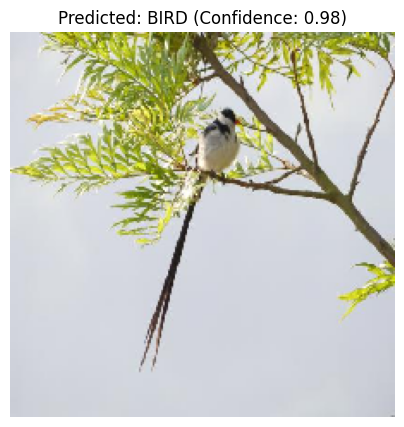

Label: bird
Confidence: 0.9802689552307129
Raw Probability: 0.019731026142835617


In [ ]:
best_model_path = f"{BEST_MODEL_DIR}/best_mobilenetv2_feature.keras"
model = tf.keras.models.load_model(best_model_path)

img_path = "/content/00bcba85dceeac4d_jpg.rf.ffd389c71d15da92bf9611e4dbd669d2.jpg"

label, conf, prob = predict_and_show(
    model,
    img_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices
)

print("Label:", label)
print("Confidence:", conf)
print("Raw Probability:", prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


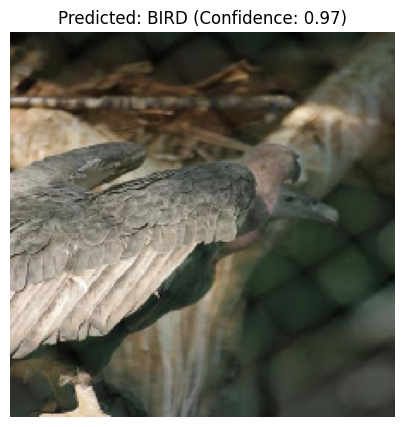

Label: bird
Confidence: 0.9726483225822449
Raw Probability: 0.02735166624188423


In [ ]:
img_path = "/content/0b0ded5a0d6ef510_jpg.rf.d504b6d675a9da7efe0bad966ce52590.jpg"

label, conf, prob = predict_and_show(
    model,
    img_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices
)

print("Label:", label)
print("Confidence:", conf)
print("Raw Probability:", prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


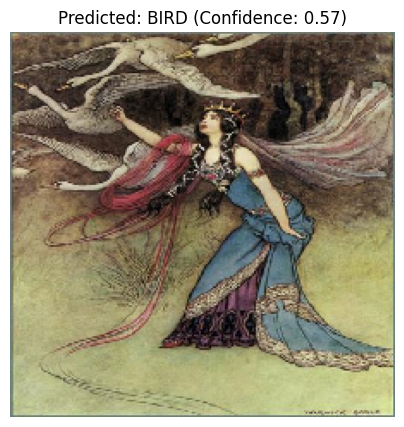

Label: bird
Confidence: 0.5741746425628662
Raw Probability: 0.4258253574371338


In [ ]:
img_path = "/content/0ac89fb83f21ca05_jpg.rf.d2f6592c1bf2fbfb4f5f998642e7b979.jpg"

label, conf, prob = predict_and_show(
    model,
    img_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices
)

print("Label:", label)
print("Confidence:", conf)
print("Raw Probability:", prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


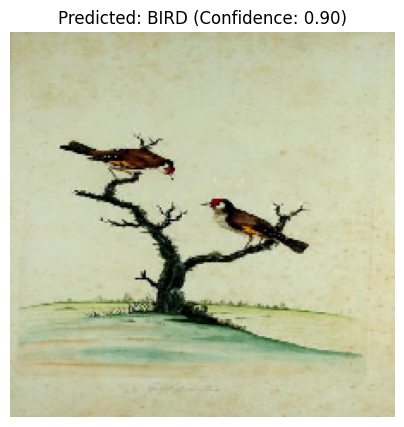

Label: bird
Confidence: 0.8974464535713196
Raw Probability: 0.10255352407693863


In [ ]:
img_path = "/content/00ae16f9f9da14c0_jpg.rf.1ed72ffd141cf839f6031bebe1ec3e36.jpg"

label, conf, prob = predict_and_show(
    model,
    img_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices
)

print("Label:", label)
print("Confidence:", conf)
print("Raw Probability:", prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


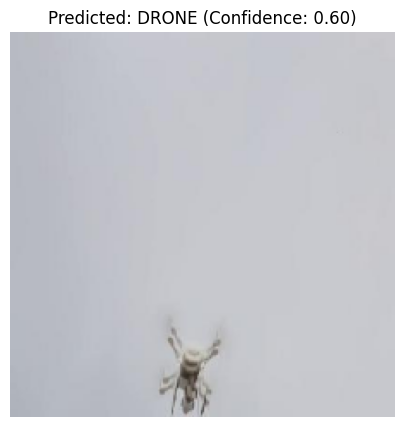

Label: drone
Confidence: 0.5964808464050293
Raw Probability: 0.5964808464050293


In [ ]:
img_path = "/content/foto00320_png.rf.bbe39f21e98c93eb519f1c06e3ea3467.jpg"

label, conf, prob = predict_and_show(
    model,
    img_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices
)

print("Label:", label)
print("Confidence:", conf)
print("Raw Probability:", prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


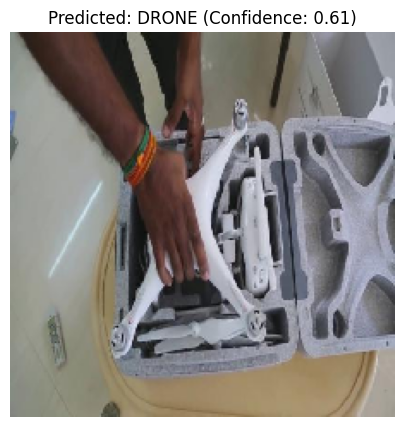

Label: drone
Confidence: 0.6076151132583618
Raw Probability: 0.6076151132583618


In [ ]:
img_path = "/content/foto01103_png.rf.f64fdc32fd599477db4e09f24bb1a86a.jpg"

label, conf, prob = predict_and_show(
    model,
    img_path,
    target_size=IMG_SIZE,
    class_indices=train_gen.class_indices
)

print("Label:", label)
print("Confidence:", conf)
print("Raw Probability:", prob)

In [ ]:
final_model_path = os.path.join(BEST_MODEL_DIR, "bird_drone_mobilenet_final.keras")

best_mobile_path = os.path.join(BEST_MODEL_DIR, "best_mobilenetv2_feature.keras")
best_mobile = tf.keras.models.load_model(best_mobile_path)

best_mobile.save(final_model_path)
print("Saved final model to:", final_model_path)


Saved final model to: /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/bird_drone_mobilenet_final.keras
